In [1]:
from torch_src.alexnet import AlexNet, HalfAlexNet
import torch
from torchvision import transforms

In [2]:
from torchvision.models import alexnet, AlexNet_Weights

alex_net = AlexNet()
alex_net
# alex_net = HalfAlexNet()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [3]:
alex_net(torch.randn(size=(2, 3, 227, 227))).sum(dim=1)

tensor([-0.3465, -0.3409], grad_fn=<SumBackward1>)

In [4]:
from torch.utils.data import DataLoader
from torch_src.data import CarDataset

In [5]:


transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(dtype=torch.float64),
    transforms.Resize(size=(227, 227))
])

dataset = CarDataset(root='data/LR1-1/', img_folder='cars_train', transform=transform)

train_dataset, test_dataset = dataset.split_dataset(train_part=0.8)
train_dataloader, test_dataloader = DataLoader(dataset, batch_size=4, shuffle=True), DataLoader(test_dataset, batch_size=4)

dict_keys(['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname'])
dict_keys(['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname'])
dict_keys(['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname'])


In [6]:
from mat4py import loadmat
import os
anno = loadmat(os.path.join('C:\\MySpace\\Projects\\PTDL\\lab1\\data\\LR1-1', 'cars_meta.mat'))
class_names = anno['class_names']

Audi TT Hatchback 2011


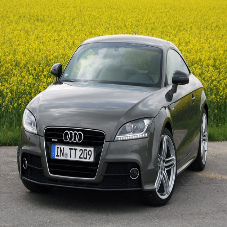

In [7]:
from PIL import Image
import numpy as np
imgs, targets = list(next(iter(train_dataloader)))
img = imgs[0]
target = targets[0]
img = torch.permute(img, (1, 2, 0)).detach().cpu().numpy()
print(class_names[target])
Image.fromarray((img * 255).astype(np.uint8))

In [8]:
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

loss = FocalLoss()

In [9]:
from torchvision.models import resnet50, ResNet50_Weights
del alex_net
resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).eval()
resnet50.fc = torch.nn.Linear(in_features=2048, out_features=196, bias=True)

In [16]:

import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
counter = {i: 0 for i in range(196)}
from torch.optim import Adam
from torch_src.optim import AdaSmooth

def train(model: torch.nn.Module, train_loader: DataLoader, test_loader: DataLoader, optimizer, criterion, epochs: int = 10):
    device = torch.device('cuda')
    model.to(device)
    for e in range(epochs):
        with tqdm(total=len(train_loader)) as t:
            full_loss = 0
            model.train()
            for i, data in enumerate(train_loader):
                batch, targets = data
                for target in targets:
                    counter[int(target.numpy())] += 1
                targets = targets.to(device)
                batch = batch.to(dtype=torch.float)
                batch = batch.to(device=device)
                out = model(batch)
                output = F.softmax(out, dim=1)
                optimizer.zero_grad()
                loss = criterion(out, targets)
                full_loss += loss.item()
                loss.backward()
                optimizer.step()

                t.update(1)
                t.set_postfix_str(f'Epoch: {e + 1} | Loss: loss: {full_loss / (i + 1)}')

        with tqdm(total=len(test_loader)) as t:
            model.eval()
            labels, predictions = list(), list()
            for i, (img, label) in enumerate(test_loader):
                labels.extend(label.detach().cpu().tolist())
                img = img.to(device=device, dtype=torch.float)
                output = model(img)
                output = F.softmax(output, dim=1)
                predictions.extend(torch.argmax(output, dim=1).detach().cpu().tolist())
                t.update(1)

            # print(labels)
            # print(predictions)
            # print(train_loader.dataset.label_names)
            print(classification_report(y_true=labels, y_pred=predictions, zero_division=0))

            print(f'Accuracy: {100 * accuracy_score(labels, predictions)}%')

In [17]:
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()

In [ ]:
from torch.optim import SGD

train(model=resnet50, train_loader=train_dataloader, test_loader=test_dataloader, optimizer=Adam(params=resnet50.parameters(), lr=0.00001, weight_decay=5e-5), criterion=loss, epochs=20)

100%|██████████| 408/408 [00:31<00:00, 12.85it/s]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00        11
          16       0.00      0.00      0.00         6
          17       0.00    

100%|██████████| 408/408 [00:31<00:00, 12.96it/s]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00        11
          16       0.00      0.00      0.00         6
          17       0.00    

 95%|█████████▍| 1931/2036 [05:25<00:15,  6.65it/s, Epoch: 3 | Loss: loss: 5.265130894965671] 

In [ ]:
counter

In [ ]:
# 4.7% Adam ResNet50
# 2.5% AdaSmooth ResNet50

In [ ]:
from torchvision.datasets import MNIST
preprocess = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Lambda(lambd=lambda x: torch.concat([x, x, x], dim=0)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mnist = MNIST(root='data/', download=True, transform=preprocess)
mnist_loader = DataLoader(dataset=mnist, batch_size=4)

In [ ]:
mnist.targets

In [ ]:
train(resnet50, mnist_loader, mnist_loader, AdaSmooth(params=resnet50.parameters(), lr=0.001), 1)

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
# del alex_net
resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).eval()
resnet50.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=2048, out_features=10, bias=True),
    torch.nn.Softmax(dim=1)
)


optimizer = AdaSmooth(params=resnet50.parameters(), lr=0.001)

In [ ]:
train(alex_net, mnist_loader, mnist_loader, 1)

In [ ]:
optimizer = Adam(params=resnet50.parameters(), lr=0.001)

In [ ]:
train(resnet50, mnist_loader, mnist_loader, 1)

In [ ]:
from torch_src.alexnet import fasion_mnist_alexnet
# model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# model.classifier[4] = torch.nn.Linear(4096,512)
# model.classifier[6] = torch.nn.Sequential(torch.nn.Linear(512,10), torch.nn.Softmax(dim=1))
model = fasion_mnist_alexnet()
model.to(device)

In [ ]:
from torch.optim import Adam
from torch_src.optim import AdaSmooth
optimizer = AdaSmooth(model.parameters(), lr=1e-3, window=3)
# optimizer = Adam(params=alex_net.parameters(), lr=5e-4)
crit = torch.nn.CrossEntropyLoss()

In [ ]:
import cv2

preprocess = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
from torchvision.datasets import MNIST

mnist = MNIST(root='data/', download=True, transform=preprocess)
mnist_loader = DataLoader(dataset=mnist, batch_size=8)

In [ ]:
image = list(next(iter(mnist_loader)))[0][0]

image = torch.permute(image, dims=(1, 2, 0))
image = image.numpy()
Image.fromarray((image[:,:,0] * 255).astype(np.uint8))

In [ ]:
import torch.nn.functional as F

crit = F.nll_loss

In [ ]:
train(model, mnist_loader, mnist_loader, Adam(model.parameters(), lr=1e-3), 1)

In [ ]:
train(model, mnist_loader, mnist_loader, optimizer, 1)